In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'native','im':'t1','fe':['b25'],'fi':['t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 1000,
    'patience'      : 7,
    'dropout'       : 0.5,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_1000_05_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_md_data_norm_b25_t1_mask_t1_native_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(631390, 934)
(631390, 1)
validation
(74368, 934)
(74368, 1)
test
(85358, 934)
(85358, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 934)]             0         


 dense (Dense)               (None, 1024)              957440    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1646593 (6.28 MB)


Trainable params: 1646593 (6.28 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/632 [..............................] - ETA: 11:40 - loss: 0.0307 - STD: 2.3786e-04 - MAE: 0.1655

 11/632 [..............................] - ETA: 3s - loss: 0.0198 - STD: 8.4654e-04 - MAE: 0.1038   

 21/632 [..............................] - ETA: 3s - loss: 0.0169 - STD: 0.0015 - MAE: 0.0857    

 31/632 [>.............................] - ETA: 3s - loss: 0.0153 - STD: 0.0025 - MAE: 0.0816

 41/632 [>.............................] - ETA: 3s - loss: 0.0144 - STD: 0.0045 - MAE: 0.0783

 51/632 [=>............................] - ETA: 3s - loss: 0.0132 - STD: 0.0098 - MAE: 0.0739

 61/632 [=>............................] - ETA: 2s - loss: 0.0120 - STD: 0.0203 - MAE: 0.0696

 72/632 [==>...........................] - ETA: 2s - loss: 0.0107 - STD: 0.0300 - MAE: 0.0651

 84/632 [==>...........................] - ETA: 2s - loss: 0.0097 - STD: 0.0396 - MAE: 0.0611

 95/632 [===>..........................] - ETA: 5s - loss: 0.0090 - STD: 0.0463 - MAE: 0.0581

107/632 [====>.........................] - ETA: 5s - loss: 0.0083 - STD: 0.0521 - MAE: 0.0556

119/632 [====>.........................] - ETA: 4s - loss: 0.0077 - STD: 0.0568 - MAE: 0.0534

130/632 [=====>........................] - ETA: 4s - loss: 0.0073 - STD: 0.0603 - MAE: 0.0518

141/632 [=====>........................] - ETA: 4s - loss: 0.0069 - STD: 0.0635 - MAE: 0.0503

152/632 [======>.......................] - ETA: 4s - loss: 0.0066 - STD: 0.0660 - MAE: 0.0490

162/632 [======>.......................] - ETA: 3s - loss: 0.0063 - STD: 0.0682 - MAE: 0.0480

172/632 [=======>......................] - ETA: 3s - loss: 0.0061 - STD: 0.0703 - MAE: 0.0470

182/632 [=======>......................] - ETA: 3s - loss: 0.0059 - STD: 0.0721 - MAE: 0.0461

194/632 [========>.....................] - ETA: 3s - loss: 0.0056 - STD: 0.0742 - MAE: 0.0452

206/632 [========>.....................] - ETA: 3s - loss: 0.0054 - STD: 0.0757 - MAE: 0.0444

218/632 [=========>....................] - ETA: 3s - loss: 0.0052 - STD: 0.0772 - MAE: 0.0437

230/632 [=========>....................] - ETA: 2s - loss: 0.0051 - STD: 0.0787 - MAE: 0.0429

242/632 [==========>...................] - ETA: 2s - loss: 0.0049 - STD: 0.0797 - MAE: 0.0423

254/632 [===========>..................] - ETA: 2s - loss: 0.0048 - STD: 0.0808 - MAE: 0.0416

266/632 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0817 - MAE: 0.0411

278/632 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0827 - MAE: 0.0406

290/632 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0836 - MAE: 0.0401

302/632 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0843 - MAE: 0.0397

314/632 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0850 - MAE: 0.0392

326/632 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0857 - MAE: 0.0389

338/632 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0863 - MAE: 0.0385

350/632 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0870 - MAE: 0.0382

362/632 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0875 - MAE: 0.0379

374/632 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0881 - MAE: 0.0376

386/632 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0887 - MAE: 0.0373

398/632 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0891 - MAE: 0.0371

410/632 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0895 - MAE: 0.0368

422/632 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0899 - MAE: 0.0366

434/632 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0903 - MAE: 0.0363

446/632 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0907 - MAE: 0.0361

457/632 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0911 - MAE: 0.0359

468/632 [=====================>........] - ETA: 0s - loss: 0.0034 - STD: 0.0914 - MAE: 0.0357

480/632 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.0917 - MAE: 0.0355

492/632 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0920 - MAE: 0.0353

504/632 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0923 - MAE: 0.0351

516/632 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0926 - MAE: 0.0350

528/632 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0929 - MAE: 0.0348

540/632 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0932 - MAE: 0.0346

552/632 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0934 - MAE: 0.0345

564/632 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0937 - MAE: 0.0343

576/632 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0939 - MAE: 0.0342

588/632 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0941 - MAE: 0.0340

600/632 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0944 - MAE: 0.0339

612/632 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0946 - MAE: 0.0338

624/632 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0948 - MAE: 0.0338

632/632 [==============================] - 5s 6ms/step - loss: 0.0029 - STD: 0.0949 - MAE: 0.0337 - val_loss: 0.0017 - val_STD: 0.0768 - val_MAE: 0.0289


Epoch 2/10000


  1/632 [..............................] - ETA: 10s - loss: 0.0017 - STD: 0.0997 - MAE: 0.0281

 11/632 [..............................] - ETA: 3s - loss: 0.0016 - STD: 0.1057 - MAE: 0.0276 

 20/632 [..............................] - ETA: 3s - loss: 0.0017 - STD: 0.1053 - MAE: 0.0278

 30/632 [>.............................] - ETA: 3s - loss: 0.0016 - STD: 0.1042 - MAE: 0.0279

 40/632 [>.............................] - ETA: 3s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0277

 50/632 [=>............................] - ETA: 3s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0277

 60/632 [=>............................] - ETA: 3s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0276

 70/632 [==>...........................] - ETA: 2s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0277

 81/632 [==>...........................] - ETA: 2s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0277

 91/632 [===>..........................] - ETA: 2s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0276

102/632 [===>..........................] - ETA: 2s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0275

114/632 [====>.........................] - ETA: 2s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0275

126/632 [====>.........................] - ETA: 2s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0279

138/632 [=====>........................] - ETA: 2s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0280

149/632 [======>.......................] - ETA: 2s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0279

160/632 [======>.......................] - ETA: 2s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0279

171/632 [=======>......................] - ETA: 2s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0278

181/632 [=======>......................] - ETA: 2s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0278

192/632 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0278

202/632 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0279

212/632 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0278

222/632 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0278

232/632 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0277

243/632 [==========>...................] - ETA: 1s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0277

253/632 [===========>..................] - ETA: 1s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0276

264/632 [===========>..................] - ETA: 1s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0276

275/632 [============>.................] - ETA: 1s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0276

285/632 [============>.................] - ETA: 1s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0276

296/632 [=============>................] - ETA: 1s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0276

306/632 [=============>................] - ETA: 1s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0276

317/632 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0276

329/632 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0275

341/632 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0275

351/632 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0275

363/632 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0275

375/632 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0275

387/632 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0275

399/632 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0274

411/632 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0274

423/632 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0274

435/632 [===================>..........] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0274

447/632 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0274

459/632 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0274

472/632 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0273

485/632 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0273

497/632 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0273

509/632 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0273

520/632 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0273

530/632 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0273

541/632 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0273

553/632 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0273

563/632 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0273

573/632 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0273

583/632 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0273

593/632 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0273

603/632 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0273

614/632 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0273

624/632 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0273

632/632 [==============================] - 3s 5ms/step - loss: 0.0016 - STD: 0.1051 - MAE: 0.0273 - val_loss: 0.0015 - val_STD: 0.0792 - val_MAE: 0.0282


Epoch 3/10000


  1/632 [..............................] - ETA: 13s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0282

 11/632 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.1081 - MAE: 0.0270 

 21/632 [..............................] - ETA: 3s - loss: 0.0016 - STD: 0.1062 - MAE: 0.0275

 31/632 [>.............................] - ETA: 3s - loss: 0.0016 - STD: 0.1061 - MAE: 0.0276

 42/632 [>.............................] - ETA: 3s - loss: 0.0016 - STD: 0.1062 - MAE: 0.0274

 54/632 [=>............................] - ETA: 2s - loss: 0.0015 - STD: 0.1067 - MAE: 0.0272

 66/632 [==>...........................] - ETA: 2s - loss: 0.0015 - STD: 0.1067 - MAE: 0.0271

 76/632 [==>...........................] - ETA: 2s - loss: 0.0015 - STD: 0.1064 - MAE: 0.0270

 86/632 [===>..........................] - ETA: 2s - loss: 0.0015 - STD: 0.1064 - MAE: 0.0268

 98/632 [===>..........................] - ETA: 2s - loss: 0.0015 - STD: 0.1066 - MAE: 0.0268

109/632 [====>.........................] - ETA: 2s - loss: 0.0015 - STD: 0.1065 - MAE: 0.0267

119/632 [====>.........................] - ETA: 2s - loss: 0.0015 - STD: 0.1065 - MAE: 0.0267

130/632 [=====>........................] - ETA: 2s - loss: 0.0015 - STD: 0.1064 - MAE: 0.0266

142/632 [=====>........................] - ETA: 2s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0266

153/632 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0266

165/632 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0266

177/632 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0266

189/632 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0265

201/632 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0265

213/632 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

226/632 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

238/632 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

250/632 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

263/632 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

276/632 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

288/632 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

299/632 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

309/632 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

318/632 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

328/632 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

338/632 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

349/632 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

359/632 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

371/632 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

384/632 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0263

396/632 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0263

408/632 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0263

420/632 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

431/632 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

441/632 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

452/632 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

463/632 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0265

475/632 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

487/632 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

499/632 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

510/632 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

520/632 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

530/632 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

541/632 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

552/632 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

562/632 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

574/632 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

586/632 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

598/632 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

610/632 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

623/632 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

632/632 [==============================] - 3s 5ms/step - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264 - val_loss: 0.0018 - val_STD: 0.0838 - val_MAE: 0.0299


Epoch 4/10000


  1/632 [..............................] - ETA: 14s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0257

 11/632 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.1068 - MAE: 0.0264 

 23/632 [>.............................] - ETA: 2s - loss: 0.0015 - STD: 0.1072 - MAE: 0.0268

 34/632 [>.............................] - ETA: 2s - loss: 0.0015 - STD: 0.1072 - MAE: 0.0272

 46/632 [=>............................] - ETA: 2s - loss: 0.0015 - STD: 0.1067 - MAE: 0.0268

 59/632 [=>............................] - ETA: 2s - loss: 0.0015 - STD: 0.1069 - MAE: 0.0266

 70/632 [==>...........................] - ETA: 2s - loss: 0.0015 - STD: 0.1064 - MAE: 0.0265

 81/632 [==>...........................] - ETA: 2s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0265

 93/632 [===>..........................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

104/632 [===>..........................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

114/632 [====>.........................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

125/632 [====>.........................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

137/632 [=====>........................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

150/632 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

163/632 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

176/632 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

189/632 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

201/632 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0263

211/632 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0263

222/632 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0263

232/632 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0263

243/632 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

253/632 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0262

263/632 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0262

273/632 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0261

284/632 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0261

294/632 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0261

304/632 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0261

316/632 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0261

328/632 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0260

340/632 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0261

352/632 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0261

364/632 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0260

376/632 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

388/632 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

400/632 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0260

412/632 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

424/632 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

436/632 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

448/632 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

461/632 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

473/632 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

486/632 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

498/632 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

510/632 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

522/632 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

534/632 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0260

546/632 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

558/632 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

570/632 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

581/632 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0259

592/632 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0259

602/632 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0259

613/632 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

623/632 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

632/632 [==============================] - 3s 5ms/step - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259 - val_loss: 0.0023 - val_STD: 0.0863 - val_MAE: 0.0337


Epoch 5/10000


  1/632 [..............................] - ETA: 15s - loss: 0.0011 - STD: 0.1083 - MAE: 0.0237

 11/632 [..............................] - ETA: 3s - loss: 0.0013 - STD: 0.1019 - MAE: 0.0256 

 21/632 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1037 - MAE: 0.0260

 31/632 [>.............................] - ETA: 3s - loss: 0.0014 - STD: 0.1040 - MAE: 0.0259

 41/632 [>.............................] - ETA: 3s - loss: 0.0014 - STD: 0.1043 - MAE: 0.0258

 52/632 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.1048 - MAE: 0.0259

 62/632 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.1050 - MAE: 0.0258

 72/632 [==>...........................] - ETA: 2s - loss: 0.0014 - STD: 0.1052 - MAE: 0.0258

 83/632 [==>...........................] - ETA: 2s - loss: 0.0014 - STD: 0.1052 - MAE: 0.0258

 93/632 [===>..........................] - ETA: 2s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0258

103/632 [===>..........................] - ETA: 2s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0257

115/632 [====>.........................] - ETA: 2s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0257

128/632 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0257

140/632 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0257

152/632 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0257

164/632 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0257

176/632 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0257

188/632 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0258

200/632 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1052 - MAE: 0.0257

212/632 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1053 - MAE: 0.0257

224/632 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0257

236/632 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0257

248/632 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0257

260/632 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0258

272/632 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0258

284/632 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0258

296/632 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0258

308/632 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0258

320/632 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0258

332/632 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0257

344/632 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0258

356/632 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0257

368/632 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0257

381/632 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0257

393/632 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0257

405/632 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0257

417/632 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0256

429/632 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0256

441/632 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0256

453/632 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0256

465/632 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0256

478/632 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0256

490/632 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0256

503/632 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0256

514/632 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0256

526/632 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0256

538/632 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0256

550/632 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

562/632 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

574/632 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

586/632 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

598/632 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

610/632 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

622/632 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

632/632 [==============================] - 3s 5ms/step - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255 - val_loss: 0.0014 - val_STD: 0.0816 - val_MAE: 0.0264


Epoch 6/10000


  1/632 [..............................] - ETA: 11s - loss: 0.0010 - STD: 0.0953 - MAE: 0.0232

 11/632 [..............................] - ETA: 3s - loss: 0.0013 - STD: 0.1087 - MAE: 0.0249 

 22/632 [>.............................] - ETA: 3s - loss: 0.0014 - STD: 0.1077 - MAE: 0.0256

 32/632 [>.............................] - ETA: 3s - loss: 0.0014 - STD: 0.1073 - MAE: 0.0258

 44/632 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.1075 - MAE: 0.0257

 56/632 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.1071 - MAE: 0.0255

 68/632 [==>...........................] - ETA: 2s - loss: 0.0013 - STD: 0.1074 - MAE: 0.0255

 80/632 [==>...........................] - ETA: 2s - loss: 0.0013 - STD: 0.1075 - MAE: 0.0254

 92/632 [===>..........................] - ETA: 2s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0253

104/632 [===>..........................] - ETA: 2s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0255

116/632 [====>.........................] - ETA: 2s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0254

128/632 [=====>........................] - ETA: 2s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0254

140/632 [=====>........................] - ETA: 2s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0253

152/632 [======>.......................] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0253

164/632 [======>.......................] - ETA: 2s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0254

176/632 [=======>......................] - ETA: 2s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0253

188/632 [=======>......................] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0253

200/632 [========>.....................] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0253

212/632 [=========>....................] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0253

224/632 [=========>....................] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0253

236/632 [==========>...................] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0252

247/632 [==========>...................] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0252

260/632 [===========>..................] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0252

272/632 [===========>..................] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0252

283/632 [============>.................] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0252

295/632 [=============>................] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0252

307/632 [=============>................] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0252

319/632 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0252

331/632 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0252

343/632 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0252

355/632 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

367/632 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

379/632 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

391/632 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0250

402/632 [==================>...........] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0250

412/632 [==================>...........] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

422/632 [===================>..........] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

432/632 [===================>..........] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

443/632 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

456/632 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

468/632 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0250

481/632 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

493/632 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0250

505/632 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

517/632 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

529/632 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

541/632 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

552/632 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

563/632 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0249

574/632 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0249

585/632 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0249

595/632 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0249

605/632 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0249

615/632 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0249

625/632 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0249

632/632 [==============================] - 3s 5ms/step - loss: 0.0013 - STD: 0.1065 - MAE: 0.0249 - val_loss: 0.0018 - val_STD: 0.0861 - val_MAE: 0.0292


Epoch 7/10000


  1/632 [..............................] - ETA: 11s - loss: 0.0012 - STD: 0.0983 - MAE: 0.0245

 12/632 [..............................] - ETA: 2s - loss: 0.0012 - STD: 0.1039 - MAE: 0.0241 

 23/632 [>.............................] - ETA: 2s - loss: 0.0012 - STD: 0.1059 - MAE: 0.0242

 34/632 [>.............................] - ETA: 2s - loss: 0.0012 - STD: 0.1061 - MAE: 0.0242

 45/632 [=>............................] - ETA: 2s - loss: 0.0012 - STD: 0.1062 - MAE: 0.0242

 55/632 [=>............................] - ETA: 2s - loss: 0.0012 - STD: 0.1063 - MAE: 0.0244

 67/632 [==>...........................] - ETA: 2s - loss: 0.0012 - STD: 0.1064 - MAE: 0.0245

 79/632 [==>...........................] - ETA: 2s - loss: 0.0012 - STD: 0.1062 - MAE: 0.0245

 91/632 [===>..........................] - ETA: 2s - loss: 0.0012 - STD: 0.1064 - MAE: 0.0245

103/632 [===>..........................] - ETA: 2s - loss: 0.0012 - STD: 0.1065 - MAE: 0.0245

115/632 [====>.........................] - ETA: 2s - loss: 0.0012 - STD: 0.1065 - MAE: 0.0245

127/632 [=====>........................] - ETA: 2s - loss: 0.0012 - STD: 0.1066 - MAE: 0.0245

137/632 [=====>........................] - ETA: 2s - loss: 0.0012 - STD: 0.1064 - MAE: 0.0245

147/632 [=====>........................] - ETA: 2s - loss: 0.0012 - STD: 0.1064 - MAE: 0.0245

158/632 [======>.......................] - ETA: 2s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0246

170/632 [=======>......................] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0246

182/632 [=======>......................] - ETA: 2s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0246

194/632 [========>.....................] - ETA: 2s - loss: 0.0012 - STD: 0.1065 - MAE: 0.0245

205/632 [========>.....................] - ETA: 1s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0245

217/632 [=========>....................] - ETA: 1s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0245

230/632 [=========>....................] - ETA: 1s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0245

243/632 [==========>...................] - ETA: 1s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0245

254/632 [===========>..................] - ETA: 1s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0245

265/632 [===========>..................] - ETA: 1s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0245

276/632 [============>.................] - ETA: 1s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0245

288/632 [============>.................] - ETA: 1s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0245

300/632 [=============>................] - ETA: 1s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0245

312/632 [=============>................] - ETA: 1s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0245

324/632 [==============>...............] - ETA: 1s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0245

336/632 [==============>...............] - ETA: 1s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0244

348/632 [===============>..............] - ETA: 1s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0245

360/632 [================>.............] - ETA: 1s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0244

372/632 [================>.............] - ETA: 1s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0244

384/632 [=================>............] - ETA: 1s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0244

396/632 [=================>............] - ETA: 1s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0244

408/632 [==================>...........] - ETA: 1s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0244

420/632 [==================>...........] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0244

432/632 [===================>..........] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0244

445/632 [====================>.........] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0244

458/632 [====================>.........] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0244

471/632 [=====================>........] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0244

484/632 [=====================>........] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0244

497/632 [======================>.......] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0244

510/632 [=======================>......] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0244

523/632 [=======================>......] - ETA: 0s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0244

536/632 [========================>.....] - ETA: 0s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0244

549/632 [=========================>....] - ETA: 0s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0244

562/632 [=========================>....] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0244

575/632 [==========================>...] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0244

588/632 [==========================>...] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0244

601/632 [===========================>..] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0244

614/632 [============================>.] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0244

627/632 [============================>.] - ETA: 0s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0243

632/632 [==============================] - 3s 5ms/step - loss: 0.0012 - STD: 0.1068 - MAE: 0.0243 - val_loss: 0.0015 - val_STD: 0.0854 - val_MAE: 0.0268


Epoch 8/10000


  1/632 [..............................] - ETA: 16s - loss: 0.0010 - STD: 0.0994 - MAE: 0.0227

 11/632 [..............................] - ETA: 3s - loss: 0.0011 - STD: 0.1070 - MAE: 0.0236 

 22/632 [>.............................] - ETA: 3s - loss: 0.0011 - STD: 0.1080 - MAE: 0.0235

 34/632 [>.............................] - ETA: 2s - loss: 0.0011 - STD: 0.1070 - MAE: 0.0236

 46/632 [=>............................] - ETA: 2s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0238

 59/632 [=>............................] - ETA: 2s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0239

 72/632 [==>...........................] - ETA: 2s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0240

 84/632 [==>...........................] - ETA: 2s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0240

 96/632 [===>..........................] - ETA: 2s - loss: 0.0012 - STD: 0.1075 - MAE: 0.0239

108/632 [====>.........................] - ETA: 2s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0239

120/632 [====>.........................] - ETA: 2s - loss: 0.0012 - STD: 0.1074 - MAE: 0.0239

132/632 [=====>........................] - ETA: 2s - loss: 0.0012 - STD: 0.1074 - MAE: 0.0239

144/632 [=====>........................] - ETA: 2s - loss: 0.0012 - STD: 0.1076 - MAE: 0.0239

156/632 [======>.......................] - ETA: 2s - loss: 0.0012 - STD: 0.1075 - MAE: 0.0239

168/632 [======>.......................] - ETA: 2s - loss: 0.0012 - STD: 0.1074 - MAE: 0.0239

180/632 [=======>......................] - ETA: 1s - loss: 0.0012 - STD: 0.1074 - MAE: 0.0239

192/632 [========>.....................] - ETA: 1s - loss: 0.0012 - STD: 0.1073 - MAE: 0.0239

204/632 [========>.....................] - ETA: 1s - loss: 0.0012 - STD: 0.1073 - MAE: 0.0239

216/632 [=========>....................] - ETA: 1s - loss: 0.0012 - STD: 0.1073 - MAE: 0.0239

228/632 [=========>....................] - ETA: 1s - loss: 0.0012 - STD: 0.1073 - MAE: 0.0238

240/632 [==========>...................] - ETA: 1s - loss: 0.0012 - STD: 0.1073 - MAE: 0.0239

253/632 [===========>..................] - ETA: 1s - loss: 0.0012 - STD: 0.1074 - MAE: 0.0238

266/632 [===========>..................] - ETA: 1s - loss: 0.0012 - STD: 0.1074 - MAE: 0.0238

278/632 [============>.................] - ETA: 1s - loss: 0.0012 - STD: 0.1074 - MAE: 0.0239

290/632 [============>.................] - ETA: 1s - loss: 0.0012 - STD: 0.1075 - MAE: 0.0238

301/632 [=============>................] - ETA: 1s - loss: 0.0012 - STD: 0.1074 - MAE: 0.0238

313/632 [=============>................] - ETA: 1s - loss: 0.0012 - STD: 0.1074 - MAE: 0.0238

325/632 [==============>...............] - ETA: 1s - loss: 0.0012 - STD: 0.1074 - MAE: 0.0238

337/632 [==============>...............] - ETA: 1s - loss: 0.0012 - STD: 0.1074 - MAE: 0.0239

349/632 [===============>..............] - ETA: 1s - loss: 0.0012 - STD: 0.1074 - MAE: 0.0239

361/632 [================>.............] - ETA: 1s - loss: 0.0012 - STD: 0.1074 - MAE: 0.0239

373/632 [================>.............] - ETA: 1s - loss: 0.0012 - STD: 0.1074 - MAE: 0.0239

385/632 [=================>............] - ETA: 1s - loss: 0.0012 - STD: 0.1073 - MAE: 0.0239

398/632 [=================>............] - ETA: 1s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0239

411/632 [==================>...........] - ETA: 0s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0240

422/632 [===================>..........] - ETA: 0s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0239

432/632 [===================>..........] - ETA: 0s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0239

444/632 [====================>.........] - ETA: 0s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0239

456/632 [====================>.........] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0239

468/632 [=====================>........] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0239

480/632 [=====================>........] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0239

492/632 [======================>.......] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0239

504/632 [======================>.......] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0239

516/632 [=======================>......] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0239

528/632 [========================>.....] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0239

539/632 [========================>.....] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0239

551/632 [=========================>....] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0240

563/632 [=========================>....] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0240

575/632 [==========================>...] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0240

587/632 [==========================>...] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0240

597/632 [===========================>..] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0240

607/632 [===========================>..] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0240

618/632 [============================>.] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0240

630/632 [============================>.] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0240

632/632 [==============================] - 3s 5ms/step - loss: 0.0012 - STD: 0.1069 - MAE: 0.0240 - val_loss: 0.0025 - val_STD: 0.0881 - val_MAE: 0.0335


Epoch 9/10000


  1/632 [..............................] - ETA: 10s - loss: 0.0013 - STD: 0.1108 - MAE: 0.0253

 11/632 [..............................] - ETA: 3s - loss: 0.0012 - STD: 0.1039 - MAE: 0.0234 

 21/632 [..............................] - ETA: 3s - loss: 0.0011 - STD: 0.1066 - MAE: 0.0235

 32/632 [>.............................] - ETA: 3s - loss: 0.0011 - STD: 0.1063 - MAE: 0.0234

 42/632 [>.............................] - ETA: 3s - loss: 0.0011 - STD: 0.1061 - MAE: 0.0234

 52/632 [=>............................] - ETA: 3s - loss: 0.0011 - STD: 0.1061 - MAE: 0.0234

 63/632 [=>............................] - ETA: 2s - loss: 0.0011 - STD: 0.1064 - MAE: 0.0233

 75/632 [==>...........................] - ETA: 2s - loss: 0.0011 - STD: 0.1067 - MAE: 0.0232

 86/632 [===>..........................] - ETA: 2s - loss: 0.0011 - STD: 0.1067 - MAE: 0.0232

 97/632 [===>..........................] - ETA: 2s - loss: 0.0011 - STD: 0.1068 - MAE: 0.0233

108/632 [====>.........................] - ETA: 2s - loss: 0.0011 - STD: 0.1070 - MAE: 0.0233

119/632 [====>.........................] - ETA: 2s - loss: 0.0011 - STD: 0.1069 - MAE: 0.0233

130/632 [=====>........................] - ETA: 2s - loss: 0.0011 - STD: 0.1069 - MAE: 0.0233

142/632 [=====>........................] - ETA: 2s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0233

154/632 [======>.......................] - ETA: 2s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0233

164/632 [======>.......................] - ETA: 2s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0233

176/632 [=======>......................] - ETA: 2s - loss: 0.0011 - STD: 0.1070 - MAE: 0.0233

186/632 [=======>......................] - ETA: 2s - loss: 0.0011 - STD: 0.1070 - MAE: 0.0233

197/632 [========>.....................] - ETA: 2s - loss: 0.0011 - STD: 0.1069 - MAE: 0.0233

209/632 [========>.....................] - ETA: 2s - loss: 0.0011 - STD: 0.1067 - MAE: 0.0233

221/632 [=========>....................] - ETA: 1s - loss: 0.0011 - STD: 0.1068 - MAE: 0.0233

233/632 [==========>...................] - ETA: 1s - loss: 0.0011 - STD: 0.1068 - MAE: 0.0233

244/632 [==========>...................] - ETA: 1s - loss: 0.0011 - STD: 0.1068 - MAE: 0.0233

254/632 [===========>..................] - ETA: 1s - loss: 0.0011 - STD: 0.1068 - MAE: 0.0233

264/632 [===========>..................] - ETA: 1s - loss: 0.0011 - STD: 0.1070 - MAE: 0.0233

274/632 [============>.................] - ETA: 1s - loss: 0.0011 - STD: 0.1069 - MAE: 0.0233

284/632 [============>.................] - ETA: 1s - loss: 0.0011 - STD: 0.1070 - MAE: 0.0233

295/632 [=============>................] - ETA: 1s - loss: 0.0011 - STD: 0.1069 - MAE: 0.0233

306/632 [=============>................] - ETA: 1s - loss: 0.0011 - STD: 0.1069 - MAE: 0.0234

318/632 [==============>...............] - ETA: 1s - loss: 0.0011 - STD: 0.1069 - MAE: 0.0234

329/632 [==============>...............] - ETA: 1s - loss: 0.0011 - STD: 0.1069 - MAE: 0.0234

339/632 [===============>..............] - ETA: 1s - loss: 0.0011 - STD: 0.1069 - MAE: 0.0234

349/632 [===============>..............] - ETA: 1s - loss: 0.0011 - STD: 0.1070 - MAE: 0.0234

361/632 [================>.............] - ETA: 1s - loss: 0.0011 - STD: 0.1070 - MAE: 0.0233

373/632 [================>.............] - ETA: 1s - loss: 0.0011 - STD: 0.1070 - MAE: 0.0234

385/632 [=================>............] - ETA: 1s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0234

397/632 [=================>............] - ETA: 1s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0234

408/632 [==================>...........] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0234

419/632 [==================>...........] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0234

429/632 [===================>..........] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0234

439/632 [===================>..........] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0234

450/632 [====================>.........] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0234

461/632 [====================>.........] - ETA: 0s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0234

471/632 [=====================>........] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0234

481/632 [=====================>........] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0234

491/632 [======================>.......] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0234

501/632 [======================>.......] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0234

511/632 [=======================>......] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0234

522/632 [=======================>......] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0234

532/632 [========================>.....] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0234

542/632 [========================>.....] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0234

552/632 [=========================>....] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0234

563/632 [=========================>....] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0234

575/632 [==========================>...] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0234

587/632 [==========================>...] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0234

599/632 [===========================>..] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0234

611/632 [============================>.] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0234

623/632 [============================>.] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0234

632/632 [==============================] - 3s 5ms/step - loss: 0.0011 - STD: 0.1073 - MAE: 0.0234 - val_loss: 0.0021 - val_STD: 0.0889 - val_MAE: 0.0303


Epoch 10/10000


  1/632 [..............................] - ETA: 13s - loss: 0.0011 - STD: 0.1144 - MAE: 0.0228

 11/632 [..............................] - ETA: 3s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0243 

 21/632 [..............................] - ETA: 3s - loss: 0.0012 - STD: 0.1075 - MAE: 0.0241

 31/632 [>.............................] - ETA: 3s - loss: 0.0012 - STD: 0.1062 - MAE: 0.0240

 41/632 [>.............................] - ETA: 2s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0237

 52/632 [=>............................] - ETA: 2s - loss: 0.0011 - STD: 0.1064 - MAE: 0.0235

 62/632 [=>............................] - ETA: 2s - loss: 0.0011 - STD: 0.1067 - MAE: 0.0235

 72/632 [==>...........................] - ETA: 2s - loss: 0.0011 - STD: 0.1061 - MAE: 0.0234

 82/632 [==>...........................] - ETA: 2s - loss: 0.0011 - STD: 0.1064 - MAE: 0.0234

 92/632 [===>..........................] - ETA: 2s - loss: 0.0011 - STD: 0.1064 - MAE: 0.0233

103/632 [===>..........................] - ETA: 2s - loss: 0.0011 - STD: 0.1064 - MAE: 0.0233

115/632 [====>.........................] - ETA: 2s - loss: 0.0011 - STD: 0.1066 - MAE: 0.0232

127/632 [=====>........................] - ETA: 2s - loss: 0.0011 - STD: 0.1070 - MAE: 0.0232

139/632 [=====>........................] - ETA: 2s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0232

151/632 [======>.......................] - ETA: 2s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0232

163/632 [======>.......................] - ETA: 2s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0232

175/632 [=======>......................] - ETA: 2s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0232

187/632 [=======>......................] - ETA: 2s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0231

199/632 [========>.....................] - ETA: 2s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0231

211/632 [=========>....................] - ETA: 1s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0231

223/632 [=========>....................] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0231

235/632 [==========>...................] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0231

247/632 [==========>...................] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0231

258/632 [===========>..................] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0231

270/632 [===========>..................] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0231

282/632 [============>.................] - ETA: 1s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0232

294/632 [============>.................] - ETA: 1s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0232

305/632 [=============>................] - ETA: 1s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0232

316/632 [==============>...............] - ETA: 1s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0232

328/632 [==============>...............] - ETA: 1s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0232

340/632 [===============>..............] - ETA: 1s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0232

352/632 [===============>..............] - ETA: 1s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0232

364/632 [================>.............] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0232

376/632 [================>.............] - ETA: 1s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0231

388/632 [=================>............] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0231

400/632 [=================>............] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0231

412/632 [==================>...........] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0232

424/632 [===================>..........] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0232

436/632 [===================>..........] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0232

448/632 [====================>.........] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0233

460/632 [====================>.........] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0233

472/632 [=====================>........] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0233

484/632 [=====================>........] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0233

496/632 [======================>.......] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0233

508/632 [=======================>......] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0232

521/632 [=======================>......] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0232

533/632 [========================>.....] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0232

545/632 [========================>.....] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0232

557/632 [=========================>....] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0232

569/632 [==========================>...] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0232

580/632 [==========================>...] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0232

592/632 [===========================>..] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0232

604/632 [===========================>..] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0233

616/632 [============================>.] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0232

628/632 [============================>.] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0232

632/632 [==============================] - 3s 5ms/step - loss: 0.0011 - STD: 0.1072 - MAE: 0.0232 - val_loss: 0.0020 - val_STD: 0.0864 - val_MAE: 0.0300


Epoch 11/10000


  1/632 [..............................] - ETA: 13s - loss: 9.7738e-04 - STD: 0.1064 - MAE: 0.0216

 11/632 [..............................] - ETA: 3s - loss: 0.0010 - STD: 0.1068 - MAE: 0.0226     

 22/632 [>.............................] - ETA: 3s - loss: 0.0011 - STD: 0.1070 - MAE: 0.0228

 35/632 [>.............................] - ETA: 2s - loss: 0.0011 - STD: 0.1064 - MAE: 0.0229

 48/632 [=>............................] - ETA: 2s - loss: 0.0011 - STD: 0.1066 - MAE: 0.0230

 61/632 [=>............................] - ETA: 2s - loss: 0.0011 - STD: 0.1061 - MAE: 0.0232

 73/632 [==>...........................] - ETA: 2s - loss: 0.0011 - STD: 0.1056 - MAE: 0.0233

 84/632 [==>...........................] - ETA: 2s - loss: 0.0011 - STD: 0.1057 - MAE: 0.0236

 95/632 [===>..........................] - ETA: 2s - loss: 0.0011 - STD: 0.1059 - MAE: 0.0237

106/632 [====>.........................] - ETA: 2s - loss: 0.0011 - STD: 0.1059 - MAE: 0.0236

118/632 [====>.........................] - ETA: 2s - loss: 0.0011 - STD: 0.1060 - MAE: 0.0236

129/632 [=====>........................] - ETA: 2s - loss: 0.0011 - STD: 0.1060 - MAE: 0.0236

140/632 [=====>........................] - ETA: 2s - loss: 0.0011 - STD: 0.1061 - MAE: 0.0235

150/632 [======>.......................] - ETA: 2s - loss: 0.0011 - STD: 0.1063 - MAE: 0.0235

160/632 [======>.......................] - ETA: 2s - loss: 0.0011 - STD: 0.1064 - MAE: 0.0234

171/632 [=======>......................] - ETA: 2s - loss: 0.0011 - STD: 0.1064 - MAE: 0.0233

182/632 [=======>......................] - ETA: 2s - loss: 0.0011 - STD: 0.1064 - MAE: 0.0233

193/632 [========>.....................] - ETA: 2s - loss: 0.0011 - STD: 0.1065 - MAE: 0.0232

203/632 [========>.....................] - ETA: 1s - loss: 0.0011 - STD: 0.1065 - MAE: 0.0232

213/632 [=========>....................] - ETA: 1s - loss: 0.0011 - STD: 0.1067 - MAE: 0.0232

223/632 [=========>....................] - ETA: 1s - loss: 0.0011 - STD: 0.1068 - MAE: 0.0231

234/632 [==========>...................] - ETA: 1s - loss: 0.0011 - STD: 0.1068 - MAE: 0.0231

244/632 [==========>...................] - ETA: 1s - loss: 0.0011 - STD: 0.1068 - MAE: 0.0231

254/632 [===========>..................] - ETA: 1s - loss: 0.0011 - STD: 0.1069 - MAE: 0.0231

264/632 [===========>..................] - ETA: 1s - loss: 0.0011 - STD: 0.1070 - MAE: 0.0231

274/632 [============>.................] - ETA: 1s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0230

285/632 [============>.................] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0230

297/632 [=============>................] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0230

308/632 [=============>................] - ETA: 1s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0230

318/632 [==============>...............] - ETA: 1s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0230

328/632 [==============>...............] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0230

338/632 [===============>..............] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0230

350/632 [===============>..............] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0231

362/632 [================>.............] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0230

373/632 [================>.............] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0231

383/632 [=================>............] - ETA: 1s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0230

394/632 [=================>............] - ETA: 1s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0231

406/632 [==================>...........] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0231

417/632 [==================>...........] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0231

429/632 [===================>..........] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0231

441/632 [===================>..........] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0231

453/632 [====================>.........] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0230

466/632 [=====================>........] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0230

478/632 [=====================>........] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0230

490/632 [======================>.......] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0230

502/632 [======================>.......] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0230

514/632 [=======================>......] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0230

526/632 [=======================>......] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0230

538/632 [========================>.....] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0230

550/632 [=========================>....] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0230

562/632 [=========================>....] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0230

574/632 [==========================>...] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0230

586/632 [==========================>...] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0230

598/632 [===========================>..] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0230

609/632 [===========================>..] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0230

620/632 [============================>.] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0230

632/632 [==============================] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0230

632/632 [==============================] - 3s 5ms/step - loss: 0.0011 - STD: 0.1074 - MAE: 0.0230 - val_loss: 0.0021 - val_STD: 0.0890 - val_MAE: 0.0303


Epoch 12/10000


  1/632 [..............................] - ETA: 10s - loss: 0.0010 - STD: 0.1111 - MAE: 0.0230

 13/632 [..............................] - ETA: 2s - loss: 0.0010 - STD: 0.1059 - MAE: 0.0223 

 25/632 [>.............................] - ETA: 2s - loss: 0.0010 - STD: 0.1070 - MAE: 0.0226

 37/632 [>.............................] - ETA: 2s - loss: 0.0011 - STD: 0.1062 - MAE: 0.0229

 49/632 [=>............................] - ETA: 2s - loss: 0.0011 - STD: 0.1057 - MAE: 0.0230

 61/632 [=>............................] - ETA: 2s - loss: 0.0011 - STD: 0.1058 - MAE: 0.0230

 73/632 [==>...........................] - ETA: 2s - loss: 0.0011 - STD: 0.1060 - MAE: 0.0229

 85/632 [===>..........................] - ETA: 2s - loss: 0.0011 - STD: 0.1062 - MAE: 0.0228

 97/632 [===>..........................] - ETA: 2s - loss: 0.0011 - STD: 0.1067 - MAE: 0.0227

107/632 [====>.........................] - ETA: 2s - loss: 0.0010 - STD: 0.1064 - MAE: 0.0227

117/632 [====>.........................] - ETA: 2s - loss: 0.0010 - STD: 0.1064 - MAE: 0.0227

127/632 [=====>........................] - ETA: 2s - loss: 0.0010 - STD: 0.1063 - MAE: 0.0227

137/632 [=====>........................] - ETA: 2s - loss: 0.0011 - STD: 0.1063 - MAE: 0.0227

147/632 [=====>........................] - ETA: 2s - loss: 0.0011 - STD: 0.1062 - MAE: 0.0228

159/632 [======>.......................] - ETA: 2s - loss: 0.0011 - STD: 0.1064 - MAE: 0.0229

171/632 [=======>......................] - ETA: 2s - loss: 0.0011 - STD: 0.1065 - MAE: 0.0229

183/632 [=======>......................] - ETA: 2s - loss: 0.0011 - STD: 0.1066 - MAE: 0.0229

195/632 [========>.....................] - ETA: 2s - loss: 0.0011 - STD: 0.1065 - MAE: 0.0228

206/632 [========>.....................] - ETA: 1s - loss: 0.0011 - STD: 0.1067 - MAE: 0.0228

216/632 [=========>....................] - ETA: 1s - loss: 0.0011 - STD: 0.1068 - MAE: 0.0228

226/632 [=========>....................] - ETA: 1s - loss: 0.0011 - STD: 0.1069 - MAE: 0.0227

236/632 [==========>...................] - ETA: 1s - loss: 0.0010 - STD: 0.1069 - MAE: 0.0227

246/632 [==========>...................] - ETA: 1s - loss: 0.0010 - STD: 0.1069 - MAE: 0.0227

256/632 [===========>..................] - ETA: 1s - loss: 0.0010 - STD: 0.1070 - MAE: 0.0227

267/632 [===========>..................] - ETA: 1s - loss: 0.0011 - STD: 0.1069 - MAE: 0.0227

279/632 [============>.................] - ETA: 1s - loss: 0.0011 - STD: 0.1070 - MAE: 0.0228

291/632 [============>.................] - ETA: 1s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0228

302/632 [=============>................] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0228

313/632 [=============>................] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0228

324/632 [==============>...............] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0228

335/632 [==============>...............] - ETA: 1s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0228

345/632 [===============>..............] - ETA: 1s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0228

356/632 [===============>..............] - ETA: 1s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0228

367/632 [================>.............] - ETA: 1s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0228

378/632 [================>.............] - ETA: 1s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0228

388/632 [=================>............] - ETA: 1s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0228

399/632 [=================>............] - ETA: 1s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0228

409/632 [==================>...........] - ETA: 1s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0228

420/632 [==================>...........] - ETA: 1s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0227

431/632 [===================>..........] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0227

442/632 [===================>..........] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0227

453/632 [====================>.........] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0227

464/632 [=====================>........] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0227

474/632 [=====================>........] - ETA: 0s - loss: 0.0010 - STD: 0.1074 - MAE: 0.0227

485/632 [======================>.......] - ETA: 0s - loss: 0.0010 - STD: 0.1075 - MAE: 0.0227

497/632 [======================>.......] - ETA: 0s - loss: 0.0010 - STD: 0.1075 - MAE: 0.0227

508/632 [=======================>......] - ETA: 0s - loss: 0.0010 - STD: 0.1075 - MAE: 0.0227

520/632 [=======================>......] - ETA: 0s - loss: 0.0010 - STD: 0.1075 - MAE: 0.0227

532/632 [========================>.....] - ETA: 0s - loss: 0.0010 - STD: 0.1074 - MAE: 0.0227

544/632 [========================>.....] - ETA: 0s - loss: 0.0010 - STD: 0.1074 - MAE: 0.0226

556/632 [=========================>....] - ETA: 0s - loss: 0.0010 - STD: 0.1074 - MAE: 0.0226

568/632 [=========================>....] - ETA: 0s - loss: 0.0010 - STD: 0.1075 - MAE: 0.0226

580/632 [==========================>...] - ETA: 0s - loss: 0.0010 - STD: 0.1075 - MAE: 0.0226

591/632 [===========================>..] - ETA: 0s - loss: 0.0010 - STD: 0.1075 - MAE: 0.0226

602/632 [===========================>..] - ETA: 0s - loss: 0.0010 - STD: 0.1075 - MAE: 0.0226

613/632 [============================>.] - ETA: 0s - loss: 0.0010 - STD: 0.1075 - MAE: 0.0226

623/632 [============================>.] - ETA: 0s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0226

632/632 [==============================] - 3s 5ms/step - loss: 0.0010 - STD: 0.1076 - MAE: 0.0226 - val_loss: 0.0017 - val_STD: 0.0852 - val_MAE: 0.0278


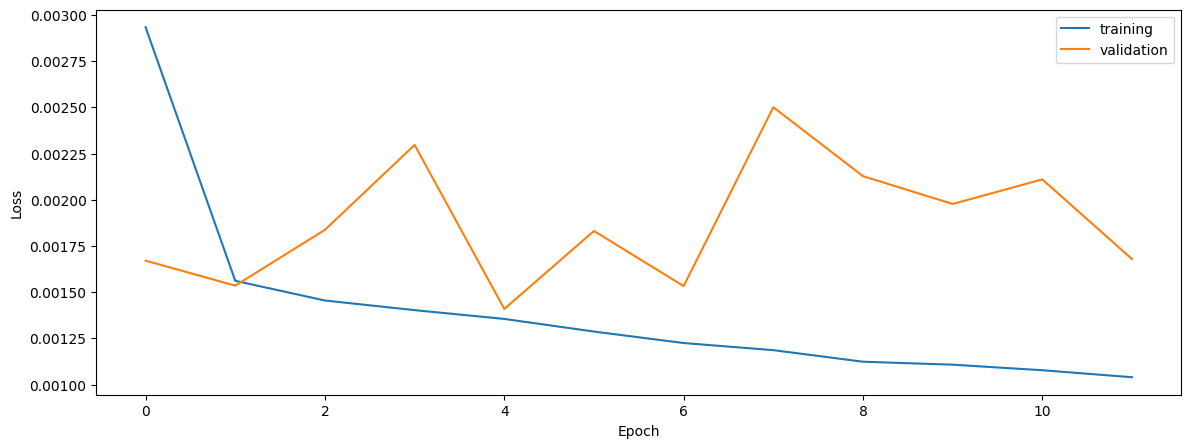

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.9490616310697751
0.959159286734881
0.9468687050970479


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

native
0.9485382168737455
0.9555593457228215
0.9502374653760053


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.9546411036887996
0.9570377725358944
0.9615643383720062


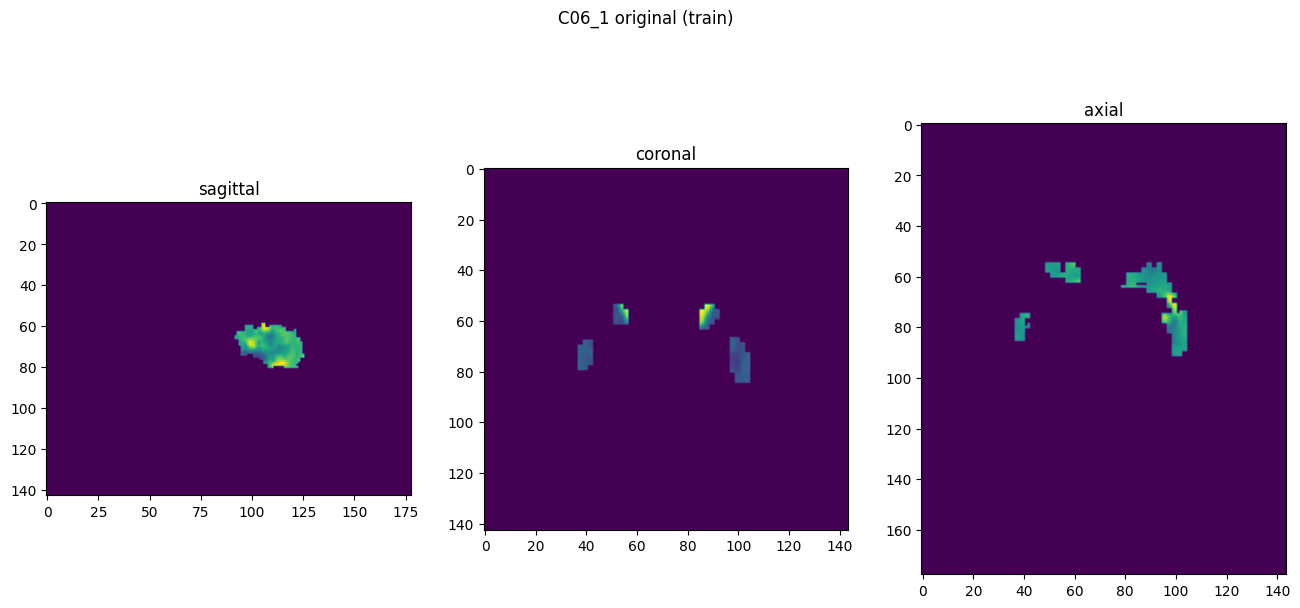

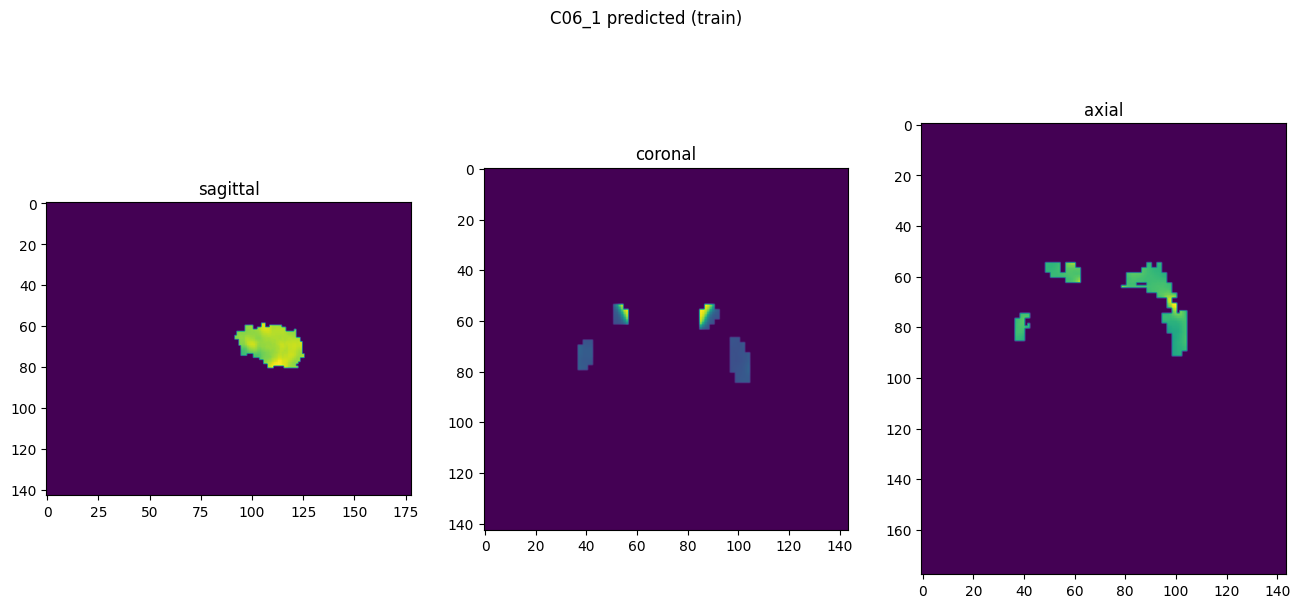

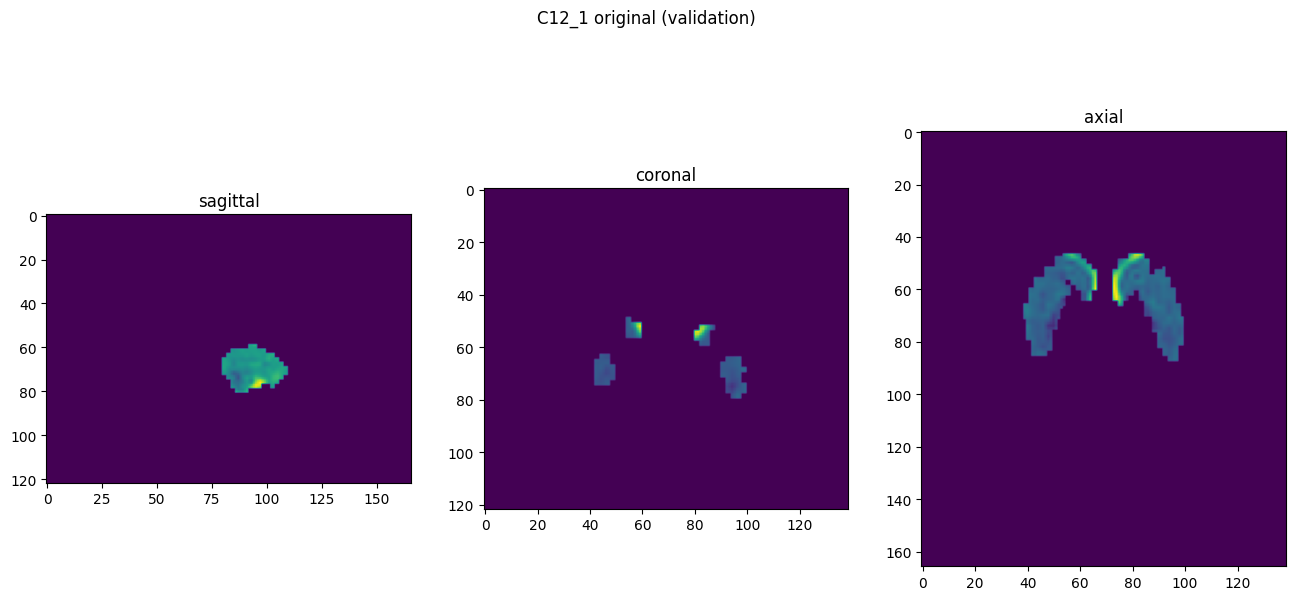

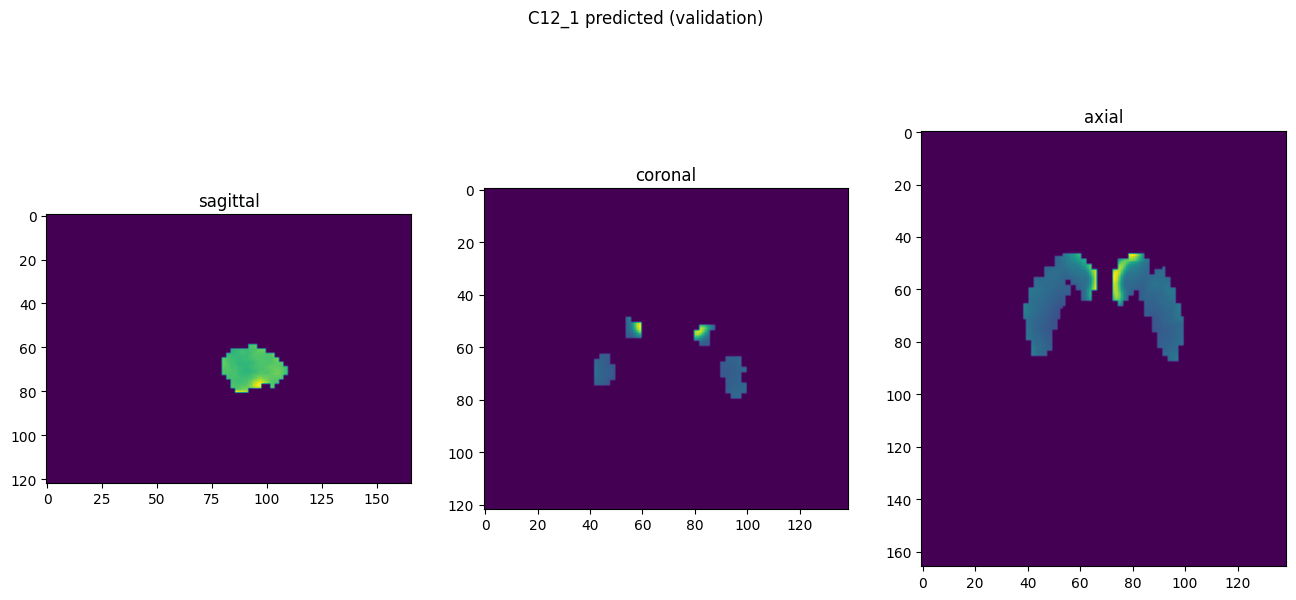

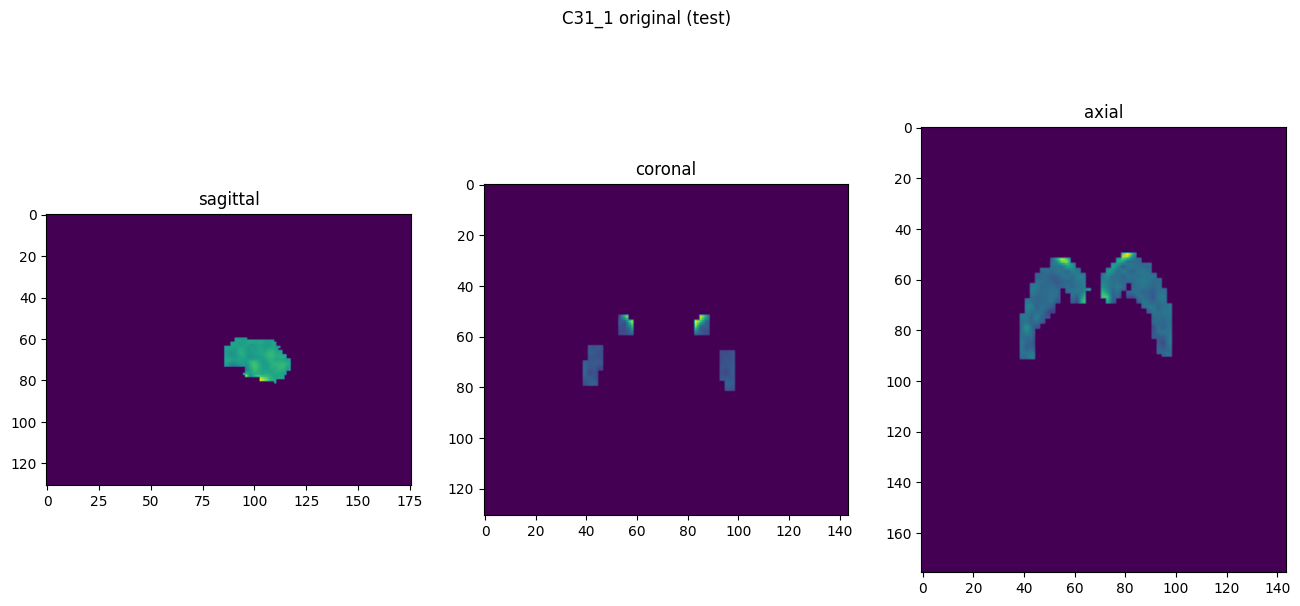

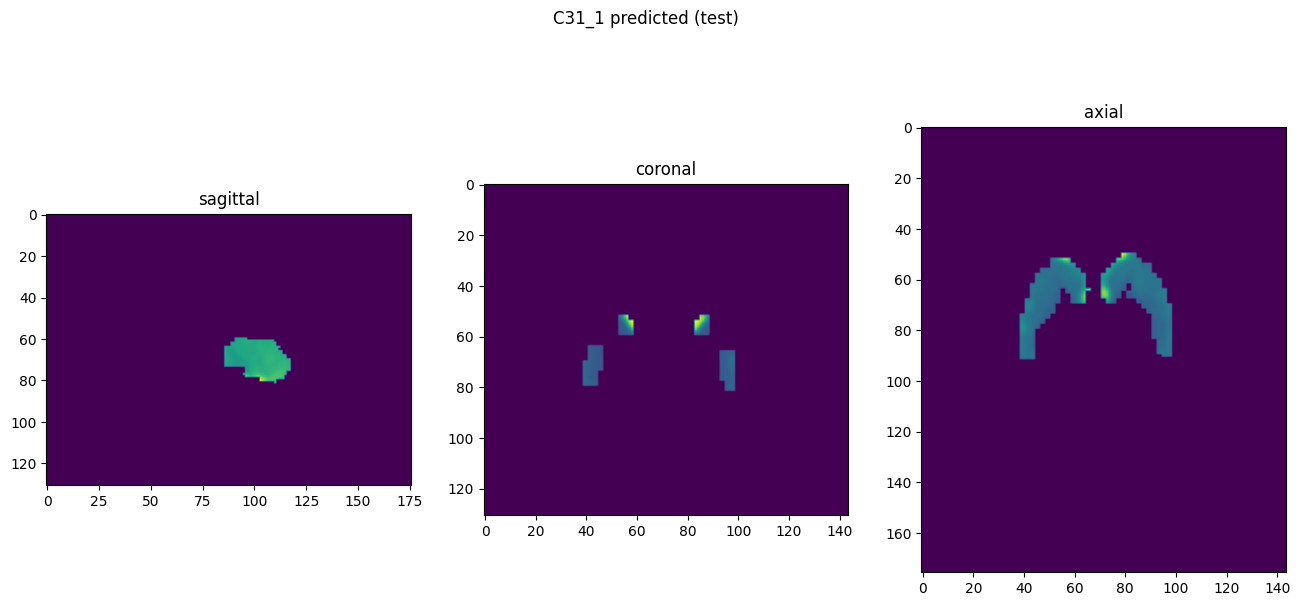

In [10]:
showResults(model, gen, threshold=None, background=False)